In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import make_swiss_roll
import numpy as np

def generate_swiss_roll_data(n_samples=1000, noise=0.5):  # Increased noise level
    data, colors = make_swiss_roll(n_samples, noise=noise)
    return data.astype(np.float32), colors.astype(np.float32)

class SwissRollDataset(Dataset):
    def __init__(self, n_samples=1000, noise=0.5):
        self.data, self.colors = generate_swiss_roll_data(n_samples, noise)
        self.data = self.data[:, [0, 2]]  # Simplify to 2D (taking x and z axes)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.colors[idx]

# Step 3: Create a DataLoader
def create_dataloader(batch_size=32, shuffle=True):
    dataset = SwissRollDataset()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

# Example usage
dataloader = create_dataloader()

In [ ]:
# Iterate through the DataLoader (example)
for i, batch in enumerate(dataloader):
    print(f"Batch {i}: Samples shape {batch['sample'].shape}, Colors shape {batch['color'].shape}")
    if i == 1:  # Just show first 2 batches
        break


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.datasets import make_swiss_roll
import numpy as np

# Data preparation
class SwissRollDataset(torch.utils.data.Dataset):
    def __init__(self, n_samples=1000):
        self.data, _ = make_swiss_roll(n_samples,noise=0.9)
        self.data = self.data.astype(np.float32)
        self.data = self.data[:, [0, 2]]  # Simplify to 2D for easier learning

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Define the generator and discriminator architectures
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.model(x)

import matplotlib.pyplot as plt

def plot_losses(d_losses, g_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generator Loss')
    plt.title('Training Losses')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Wasserstein Loss with Gradient Penalty
def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1)
    alpha = alpha.expand_as(real_samples).to(device)

    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(real_samples.shape[0], 1).requires_grad_(False).to(device)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True)[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# Training settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
lr = 0.0001
n_epochs = 1000
lambda_gp = 10

# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# DataLoader
dataset = SwissRollDataset()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Loss records
d_losses = []
g_losses = []

# Training Loop
for epoch in range(n_epochs):
    for i, real_samples in enumerate(dataloader):
        real_samples = real_samples.to(device)

        # Train Discriminator
        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = torch.randn(real_samples.shape[0], 2).to(device)
        fake_samples = generator(z)

        real_validity = discriminator(real_samples)
        fake_validity = discriminator(fake_samples)
        gradient_penalty = compute_gradient_penalty(discriminator, real_samples.data, fake_samples.data)

        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty
        d_loss.backward()
        optimizer_D.step()

        # Record the discriminator loss
        d_losses.append(d_loss.item())

        # Generator update
        optimizer_G.zero_grad()
        fake_samples = generator(z)
        loss_G = -torch.mean(discriminator(fake_samples))
        loss_G.backward()
        optimizer_G.step()

        # Record the generator loss
        g_losses.append(loss_G.item())

        if i % 50 == 0:
            print(f"Epoch: {epoch}/{n_epochs}, Batch: {i}, D loss: {d_loss.item()}, G loss: {loss_G.item()}")

plot_losses(d_losses, g_losses)


TypeError: SwissRollDataset.__init__() got an unexpected keyword argument 'noise'

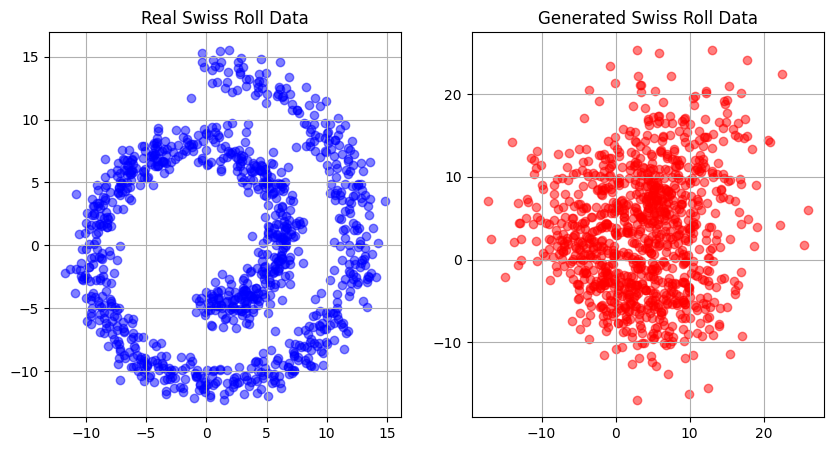

In [9]:
import matplotlib.pyplot as plt

def generate_samples(generator, num_samples=1000):
    # Generate points in the latent space
    z = torch.randn(num_samples, 2).to(device)
    # Generate samples
    samples = generator(z)
    return samples.detach().cpu().numpy()

def plot_swiss_roll(real_data, generated_data):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title('Real Swiss Roll Data')
    plt.scatter(real_data[:, 0], real_data[:, 1], c='blue', alpha=0.5)
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.title('Generated Swiss Roll Data')
    plt.scatter(generated_data[:, 0], generated_data[:, 1], c='red', alpha=0.5)
    plt.grid(True)

    plt.show()

# Example of generating samples and plotting them
# Assume generator is already trained and available
generated_samples = generate_samples(generator, num_samples=1000)
real_samples, _ = make_swiss_roll(1000,noise=0.9)  # Using Scikit-Learn to get real Swiss Roll data
real_samples = real_samples[:, [0, 2]]  # Simplify to 2D for easier learning and plotting

plot_swiss_roll(real_samples, generated_samples)
